I want to maximize the flow of valves. Each valve can be represented in a network as a node, I can perform a search, but there are several elements to account for. I will spend time opening a valve, thus it can be more efficient to skip opening one and moving on. The search algorithm will have the oportunity to visit the same nodes as many times as possible, but will only be able to open a valve once. The flow is dependent on time, so the maximizing of flow is not only dependent on visiting the nodes with the highest value, but also visiting them as soon as possible.

In [114]:
import networkx as nx
import regex as re
import heapq
import numpy as np
import pandas as pd
from collections import deque

# Final edit

In [286]:
with open("input.txt") as f:
    data = f.read()
data = data.split("\n")[:-1]

def valve_node_from_input(data):
    valve_flow = re.findall("(?:Valve\s)(\w+)(?:.+=)(\d+)",data)
    return valve_flow[0]

def edge_from_input(data):
    nodes = re.findall("[A-Z]{2}",data)
    edges = []
    for node in nodes[1:]:
        edge = (nodes[0],node)
        edges.append(edge)
    return edges

valve_node = [valve_node_from_input(node) for node in data]

nodes = {}
for node, flow in valve_node:
    nodes[node] = {"flow": int(flow)}
    
G = nx.Graph()
for node in nodes:
    G.add_node(node)
    
edge_list = []
for valve_input in data:
    edges = edge_from_input(valve_input)
    edge_list.extend(edges)

for edge in edge_list:
    G.add_edge(edge[0],edge[1])
    
nodes_numerate = {}
for i, node in enumerate(nodes.keys()):
    nodes_numerate[node] = i

# I create a matrix of all shortest distances between each pair of nodes using the Floyd-Warshall algorithm
# let dist be a |V| × |V| array of minimum distances initialized to ∞ (infinity)
fw_matrix = np.matrix(np.ones((len(G),len(G)))*np.inf)
# for each edge (u, v) do
#     dist[u][v] ← w(u, v)  // The weight of the edge (u, v)
for edge in G.edges():
    fw_matrix[nodes_numerate[edge[0]],nodes_numerate[edge[1]]] = 1
    fw_matrix[nodes_numerate[edge[1]],nodes_numerate[edge[0]]] = 1
# for each vertex v do
#     dist[v][v] ← 0
for node in G.nodes():
    fw_matrix[nodes_numerate[node],nodes_numerate[node]] = 0
# for k from 1 to |V|
#     for i from 1 to |V|
#         for j from 1 to |V|
#             if dist[i][j] > dist[i][k] + dist[k][j] 
#                 dist[i][j] ← dist[i][k] + dist[k][j]
#             end if
for k in range(len(G)):
    for i in range(len(G)):
        for j in range(len(G)):
            if fw_matrix[i,j] > fw_matrix[i,k]+fw_matrix[k,j]:
                fw_matrix[i,j] = fw_matrix[i,k]+fw_matrix[k,j]

dist = pd.DataFrame(fw_matrix, columns = nodes_numerate.keys(), index= nodes_numerate.keys())                

# for valve in valves:
#     input = (time_remaining - steps - opening) * flowrate
paths = []
# initialize starting point, flow and time
node_start = (29, 0, 30, [0] )

# Initialize a que
que = deque()
que.append(node_start)

while len(que) > 0:
    # For each of the sequences i make an empty row for the flow values
    row = []
    
    # I pop the leftmost node to be evaluated
    current_node = que.popleft()
    
    # For each node in the network i evaluate the possible flow if traveled to directly
    for j in range(len(G)):
        
        i = current_node[0]
        
        # If the node is the same node or has already been visited i skip it
        if  (i == j) | (j in current_node[3]):
            row.append(0)
            continue
        
        # Otherwise I calculate the distance between the current and target node, and calculate the flow
        # If I traveled from current to target ignoring other nodes along the way
        flow_max = (current_node[2] - fw_matrix[i,j] - 1) * nodes[dist.columns[j]]["flow"]
        row.append(flow_max)
        
        # If all values are 0 all valves has been visited and opened, and the path is as long as possible
        if sum(row)==0:
            paths.append(current_node)
    
    # For each of the non-zero values in the row I assign the values to the current node, and append it in the que 
    # as a new node
    for k, max_flow in enumerate(row):
        if max_flow == 0:
            continue
        path = current_node[3].copy()
        path.append(k)
        path_node = (k, current_node[1]+max_flow, current_node[2]-fw_matrix[i,k]-1, path)
        if path_node[2] <= 0:
            paths.append(path_node)
        else:
            que.append(path_node)
        
print(sorted(paths,key=lambda x: x[1], reverse=True)[0])

(8, 1789.0, 1.0, [0, 43, 45, 48, 9, 50, 15, 8])


## Building the network

In [2]:
data = """Valve AA has flow rate=0; tunnels lead to valves DD, II, BB
Valve BB has flow rate=13; tunnels lead to valves CC, AA
Valve CC has flow rate=2; tunnels lead to valves DD, BB
Valve DD has flow rate=20; tunnels lead to valves CC, AA, EE
Valve EE has flow rate=3; tunnels lead to valves FF, DD
Valve FF has flow rate=0; tunnels lead to valves EE, GG
Valve GG has flow rate=0; tunnels lead to valves FF, HH
Valve HH has flow rate=22; tunnel leads to valve GG
Valve II has flow rate=0; tunnels lead to valves AA, JJ
Valve JJ has flow rate=21; tunnel leads to valve II""".split("\n")

In [3]:
data

['Valve AA has flow rate=0; tunnels lead to valves DD, II, BB',
 'Valve BB has flow rate=13; tunnels lead to valves CC, AA',
 'Valve CC has flow rate=2; tunnels lead to valves DD, BB',
 'Valve DD has flow rate=20; tunnels lead to valves CC, AA, EE',
 'Valve EE has flow rate=3; tunnels lead to valves FF, DD',
 'Valve FF has flow rate=0; tunnels lead to valves EE, GG',
 'Valve GG has flow rate=0; tunnels lead to valves FF, HH',
 'Valve HH has flow rate=22; tunnel leads to valve GG',
 'Valve II has flow rate=0; tunnels lead to valves AA, JJ',
 'Valve JJ has flow rate=21; tunnel leads to valve II']

In [258]:
with open("input.txt") as f:
    data = f.read()
data = data.split("\n")[:-1]

In [260]:
def valve_node_from_input(data):
    valve_flow = re.findall("(?:Valve\s)(\w+)(?:.+=)(\d+)",data)
    return valve_flow[0]

def edge_from_input(data):
    nodes = re.findall("[A-Z]{2}",data)
    edges = []
    for node in nodes[1:]:
        edge = (nodes[0],node)
        edges.append(edge)
    return edges

def edge_to_dict(data):
    nodes = re.findall("[A-Z]{2}",data)
    return {nodes[0]:nodes[1:]}

In [261]:
valve_node = [valve_node_from_input(node) for node in data]

In [262]:
nodes = {}
for node, flow in valve_node:
    nodes[node] = {"flow": int(flow), "visited":False}

In [263]:
nodes

{'AW': {'flow': 0, 'visited': False},
 'OM': {'flow': 0, 'visited': False},
 'BG': {'flow': 0, 'visited': False},
 'XB': {'flow': 0, 'visited': False},
 'CD': {'flow': 0, 'visited': False},
 'VF': {'flow': 0, 'visited': False},
 'HK': {'flow': 0, 'visited': False},
 'QN': {'flow': 0, 'visited': False},
 'OF': {'flow': 4, 'visited': False},
 'QB': {'flow': 14, 'visited': False},
 'ZE': {'flow': 7, 'visited': False},
 'OW': {'flow': 0, 'visited': False},
 'MA': {'flow': 0, 'visited': False},
 'MP': {'flow': 0, 'visited': False},
 'UE': {'flow': 9, 'visited': False},
 'QR': {'flow': 24, 'visited': False},
 'TQ': {'flow': 0, 'visited': False},
 'SE': {'flow': 0, 'visited': False},
 'AQ': {'flow': 20, 'visited': False},
 'XE': {'flow': 0, 'visited': False},
 'DC': {'flow': 8, 'visited': False},
 'ZM': {'flow': 0, 'visited': False},
 'VK': {'flow': 21, 'visited': False},
 'VR': {'flow': 0, 'visited': False},
 'BH': {'flow': 0, 'visited': False},
 'ZR': {'flow': 0, 'visited': False},
 'JE': {

In [264]:
G = nx.Graph()
for node in nodes:
    G.add_node(node)

In [265]:
edge_list = []
for valve_input in data:
    edges = edge_from_input(valve_input)
    edge_list.extend(edges)

In [266]:
edge_list

[('AW', 'LG'),
 ('AW', 'TL'),
 ('OM', 'XK'),
 ('OM', 'IM'),
 ('BG', 'MP'),
 ('BG', 'SB'),
 ('XB', 'MA'),
 ('XB', 'TL'),
 ('CD', 'VL'),
 ('CD', 'OF'),
 ('VF', 'CS'),
 ('VF', 'XK'),
 ('HK', 'RL'),
 ('HK', 'QB'),
 ('QN', 'IV'),
 ('QN', 'QR'),
 ('OF', 'TQ'),
 ('OF', 'CD'),
 ('OF', 'IR'),
 ('OF', 'IM'),
 ('OF', 'JE'),
 ('QB', 'HK'),
 ('QB', 'XE'),
 ('QB', 'CS'),
 ('QB', 'VO'),
 ('ZE', 'JB'),
 ('ZE', 'NC'),
 ('ZE', 'SE'),
 ('ZE', 'OI'),
 ('OW', 'MB'),
 ('OW', 'JB'),
 ('MA', 'XB'),
 ('MA', 'MB'),
 ('MP', 'VK'),
 ('MP', 'BG'),
 ('UE', 'ZM'),
 ('UE', 'RZ'),
 ('UE', 'WI'),
 ('UE', 'HO'),
 ('UE', 'FO'),
 ('QR', 'QN'),
 ('TQ', 'OF'),
 ('TQ', 'AA'),
 ('SE', 'ZE'),
 ('SE', 'ZZ'),
 ('AQ', 'CX'),
 ('XE', 'JQ'),
 ('XE', 'QB'),
 ('DC', 'ZD'),
 ('DC', 'MJ'),
 ('DC', 'RZ'),
 ('ZM', 'YJ'),
 ('ZM', 'UE'),
 ('VK', 'MP'),
 ('VR', 'WV'),
 ('VR', 'PS'),
 ('BH', 'AA'),
 ('BH', 'MB'),
 ('ZR', 'LG'),
 ('ZR', 'AI'),
 ('JE', 'OF'),
 ('JE', 'HO'),
 ('IR', 'IV'),
 ('IR', 'OF'),
 ('FO', 'XQ'),
 ('FO', 'UE'),
 ('AA', 'N

In [267]:
edge_dict = {}
for node in data:
    node_edges = re.findall("[A-Z]{2}",node)
    edge_dict[node_edges[0]] = node_edges[1:]

In [268]:
edge_dict

{'AW': ['LG', 'TL'],
 'OM': ['XK', 'IM'],
 'BG': ['MP', 'SB'],
 'XB': ['MA', 'TL'],
 'CD': ['VL', 'OF'],
 'VF': ['CS', 'XK'],
 'HK': ['RL', 'QB'],
 'QN': ['IV', 'QR'],
 'OF': ['TQ', 'CD', 'IR', 'IM', 'JE'],
 'QB': ['HK', 'XE', 'CS', 'VO'],
 'ZE': ['JB', 'NC', 'SE', 'OI'],
 'OW': ['MB', 'JB'],
 'MA': ['XB', 'MB'],
 'MP': ['VK', 'BG'],
 'UE': ['ZM', 'RZ', 'WI', 'HO', 'FO'],
 'QR': ['QN'],
 'TQ': ['OF', 'AA'],
 'SE': ['ZE', 'ZZ'],
 'AQ': ['CX'],
 'XE': ['JQ', 'QB'],
 'DC': ['ZD', 'MJ', 'RZ'],
 'ZM': ['YJ', 'UE'],
 'VK': ['MP'],
 'VR': ['WV', 'PS'],
 'BH': ['AA', 'MB'],
 'ZR': ['LG', 'AI'],
 'JE': ['OF', 'HO'],
 'IR': ['IV', 'OF'],
 'FO': ['XQ', 'UE'],
 'AA': ['NC', 'VY', 'BH', 'TQ', 'YJ'],
 'ZZ': ['SE', 'TL'],
 'XQ': ['IV', 'FO'],
 'WI': ['UE', 'VO'],
 'VY': ['AA', 'LG'],
 'XK': ['VF', 'OM', 'ZD'],
 'CX': ['AQ', 'MB'],
 'JQ': ['XE', 'IV'],
 'LG': ['VY', 'PS', 'ZR', 'AW', 'OI'],
 'JB': ['ZE', 'OW'],
 'OI': ['ZE', 'LG'],
 'YJ': ['ZM', 'AA'],
 'NC': ['AA', 'ZE'],
 'KR': ['SB', 'MJ'],
 'MB': 

In [269]:
for edge in edge_list:
    G.add_edge(edge[0],edge[1])

In [270]:
edge_list

[('AW', 'LG'),
 ('AW', 'TL'),
 ('OM', 'XK'),
 ('OM', 'IM'),
 ('BG', 'MP'),
 ('BG', 'SB'),
 ('XB', 'MA'),
 ('XB', 'TL'),
 ('CD', 'VL'),
 ('CD', 'OF'),
 ('VF', 'CS'),
 ('VF', 'XK'),
 ('HK', 'RL'),
 ('HK', 'QB'),
 ('QN', 'IV'),
 ('QN', 'QR'),
 ('OF', 'TQ'),
 ('OF', 'CD'),
 ('OF', 'IR'),
 ('OF', 'IM'),
 ('OF', 'JE'),
 ('QB', 'HK'),
 ('QB', 'XE'),
 ('QB', 'CS'),
 ('QB', 'VO'),
 ('ZE', 'JB'),
 ('ZE', 'NC'),
 ('ZE', 'SE'),
 ('ZE', 'OI'),
 ('OW', 'MB'),
 ('OW', 'JB'),
 ('MA', 'XB'),
 ('MA', 'MB'),
 ('MP', 'VK'),
 ('MP', 'BG'),
 ('UE', 'ZM'),
 ('UE', 'RZ'),
 ('UE', 'WI'),
 ('UE', 'HO'),
 ('UE', 'FO'),
 ('QR', 'QN'),
 ('TQ', 'OF'),
 ('TQ', 'AA'),
 ('SE', 'ZE'),
 ('SE', 'ZZ'),
 ('AQ', 'CX'),
 ('XE', 'JQ'),
 ('XE', 'QB'),
 ('DC', 'ZD'),
 ('DC', 'MJ'),
 ('DC', 'RZ'),
 ('ZM', 'YJ'),
 ('ZM', 'UE'),
 ('VK', 'MP'),
 ('VR', 'WV'),
 ('VR', 'PS'),
 ('BH', 'AA'),
 ('BH', 'MB'),
 ('ZR', 'LG'),
 ('ZR', 'AI'),
 ('JE', 'OF'),
 ('JE', 'HO'),
 ('IR', 'IV'),
 ('IR', 'OF'),
 ('FO', 'XQ'),
 ('FO', 'UE'),
 ('AA', 'N

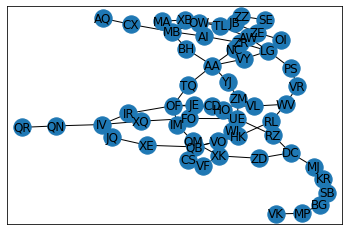

In [271]:
nx.draw_networkx(G)

## Floyd-Warshal


In [272]:
nodes_numerate = {}
for i, node in enumerate(G.nodes()):
    nodes_numerate[node] = i

In [273]:
nodes_numerate

{'AW': 0,
 'OM': 1,
 'BG': 2,
 'XB': 3,
 'CD': 4,
 'VF': 5,
 'HK': 6,
 'QN': 7,
 'OF': 8,
 'QB': 9,
 'ZE': 10,
 'OW': 11,
 'MA': 12,
 'MP': 13,
 'UE': 14,
 'QR': 15,
 'TQ': 16,
 'SE': 17,
 'AQ': 18,
 'XE': 19,
 'DC': 20,
 'ZM': 21,
 'VK': 22,
 'VR': 23,
 'BH': 24,
 'ZR': 25,
 'JE': 26,
 'IR': 27,
 'FO': 28,
 'AA': 29,
 'ZZ': 30,
 'XQ': 31,
 'WI': 32,
 'VY': 33,
 'XK': 34,
 'CX': 35,
 'JQ': 36,
 'LG': 37,
 'JB': 38,
 'OI': 39,
 'YJ': 40,
 'NC': 41,
 'KR': 42,
 'MB': 43,
 'AI': 44,
 'TL': 45,
 'RL': 46,
 'CS': 47,
 'WV': 48,
 'ZD': 49,
 'IV': 50,
 'PS': 51,
 'RZ': 52,
 'VO': 53,
 'MJ': 54,
 'IM': 55,
 'VL': 56,
 'SB': 57,
 'HO': 58}

In [275]:

# Psydo:
# let dist be a |V| × |V| array of minimum distances initialized to ∞ (infinity)
fw_matrix = np.matrix(np.ones((len(G),len(G)))*np.inf)
# for each edge (u, v) do
#     dist[u][v] ← w(u, v)  // The weight of the edge (u, v)
for edge in G.edges():
    fw_matrix[nodes_numerate[edge[0]],nodes_numerate[edge[1]]] = 1
    fw_matrix[nodes_numerate[edge[1]],nodes_numerate[edge[0]]] = 1
# for each vertex v do
#     dist[v][v] ← 0
for node in G.nodes():
    fw_matrix[nodes_numerate[node],nodes_numerate[node]] = 0
# for k from 1 to |V|
#     for i from 1 to |V|
#         for j from 1 to |V|
#             if dist[i][j] > dist[i][k] + dist[k][j] 
#                 dist[i][j] ← dist[i][k] + dist[k][j]
#             end if

for k in range(len(G)):
    for i in range(len(G)):
        for j in range(len(G)):
            if fw_matrix[i,j] > fw_matrix[i,k]+fw_matrix[k,j]:
                fw_matrix[i,j] = fw_matrix[i,k]+fw_matrix[k,j]

In [276]:
dist = pd.DataFrame(fw_matrix, columns = nodes_numerate.keys(), index= nodes_numerate.keys())
dist

,AW,OM,BG,XB,CD,VF,HK,QN,OF,QB,...,ZD,IV,PS,RZ,VO,MJ,IM,VL,SB,HO
AW,0.0,7.0,12.0,2.0,6.0,9.0,6.0,8.0,5.0,7.0,...,9.0,7.0,2.0,7.0,8.0,9.0,6.0,5.0,11.0,7.0
OM,7.0,0.0,7.0,8.0,3.0,2.0,5.0,5.0,2.0,4.0,...,2.0,4.0,7.0,4.0,5.0,4.0,1.0,4.0,6.0,4.0
BG,12.0,7.0,0.0,13.0,10.0,7.0,10.0,10.0,9.0,9.0,...,5.0,9.0,12.0,5.0,8.0,3.0,8.0,11.0,1.0,7.0
XB,2.0,8.0,13.0,0.0,7.0,10.0,8.0,9.0,6.0,9.0,...,10.0,8.0,4.0,8.0,9.0,10.0,7.0,7.0,12.0,8.0
CD,6.0,3.0,10.0,7.0,0.0,5.0,4.0,4.0,1.0,5.0,...,5.0,3.0,4.0,5.0,6.0,7.0,2.0,1.0,9.0,3.0
VF,9.0,2.0,7.0,10.0,5.0,0.0,3.0,6.0,4.0,2.0,...,2.0,5.0,7.0,4.0,3.0,4.0,3.0,6.0,6.0,6.0
HK,6.0,5.0,10.0,8.0,4.0,3.0,0.0,5.0,5.0,1.0,...,5.0,4.0,4.0,5.0,2.0,7.0,6.0,3.0,9.0,5.0
QN,8.0,5.0,10.0,9.0,4.0,6.0,5.0,0.0,3.0,4.0,...,7.0,1.0,8.0,5.0,5.0,7.0,4.0,5.0,9.0,5.0
OF,5.0,2.0,9.0,6.0,1.0,4.0,5.0,3.0,0.0,5.0,...,4.0,2.0,5.0,4.0,5.0,6.0,1.0,2.0,8.0,2.0
QB,7.0,4.0,9.0,9.0,5.0,2.0,1.0,4.0,5.0,0.0,...,4.0,3.0,5.0,4.0,1.0,6.0,5.0,4.0,8.0,4.0


In [279]:
# for valve in valves:
#     input = (time_remaining - steps - opening) * flowrate
paths = []
# initialize starting point, flow and time
node_start = (29, 0, 30, [0] )

# Initialize a que
que = deque()
que.append(node_start)

while len(que) > 0:
    # For each of the sequences i make an empty row for the flow values
    row = []
    
    # I pop the leftmost node to be evaluated
    current_node = que.popleft()
    
    # For each node in the network i evaluate the possible flow if traveled to directly
    for j in range(len(G)):
        
        i = current_node[0]
        
        # If the node is the same node or has already been visited i skip it
        if  (i == j) | (j in current_node[3]):
            row.append(0)
            continue
        
        # Otherwise I calculate the distance between the current and target node, and calculate the flow
        # If I traveled from current to target ignoring other nodes along the way
        flow_max = (current_node[2] - fw_matrix[i,j] - 1) * nodes[dist.columns[j]]["flow"]
        row.append(flow_max)
        
        # If all values are 0 all valves has been visited and opened, and the path is as long as possible
        if sum(row)==0:
            paths.append(current_node)
    
    # For each of the non-zero values in the row I assign the values to the current node, and append it in the que 
    # as a new node
    for k, max_flow in enumerate(row):
        if max_flow == 0:
            continue
        path = current_node[3].copy()
        path.append(k)
        path_node = (k, current_node[1]+max_flow, current_node[2]-fw_matrix[i,k]-1, path)
        if path_node[2] <= 0:
            paths.append(path_node)
        else:
            que.append(path_node)
        


In [280]:
sorted(paths,key=lambda x: x[1], reverse=True)

[(8, 1789.0, 1.0, [0, 43, 45, 48, 9, 50, 15, 8]),
 (8, 1789.0, 1.0, [0, 43, 45, 48, 9, 50, 15, 8]),
 (8, 1789.0, 1.0, [0, 43, 45, 48, 9, 50, 15, 8]),
 (8, 1789.0, 1.0, [0, 43, 45, 48, 9, 50, 15, 8]),
 (8, 1789.0, 1.0, [0, 43, 45, 48, 9, 50, 15, 8]),
 (8, 1789.0, 1.0, [0, 43, 45, 48, 9, 50, 15, 8]),
 (8, 1789.0, 1.0, [0, 43, 45, 48, 9, 50, 15, 8]),
 (15, 1785.0, 6.0, [0, 43, 45, 48, 9, 50, 15]),
 (15, 1785.0, 6.0, [0, 43, 45, 48, 9, 50, 15]),
 (15, 1785.0, 6.0, [0, 43, 45, 48, 9, 50, 15]),
 (15, 1785.0, 6.0, [0, 43, 45, 48, 9, 50, 15]),
 (15, 1785.0, 6.0, [0, 43, 45, 48, 9, 50, 15]),
 (15, 1785.0, 6.0, [0, 43, 45, 48, 9, 50, 15]),
 (15, 1785.0, 6.0, [0, 43, 45, 48, 9, 50, 15]),
 (37, 1777.0, -4.0, [0, 43, 45, 48, 9, 50, 15, 8, 37]),
 (37, 1776.0, -3.0, [0, 43, 45, 48, 9, 50, 15, 37]),
 (20, 1769.0, -2.0, [0, 43, 45, 48, 9, 50, 15, 20]),
 (10, 1764.0, -3.0, [0, 43, 45, 48, 9, 50, 15, 10]),
 (14, 1762.0, -3.0, [0, 43, 45, 48, 9, 50, 15, 8, 14]),
 (10, 1761.0, -4.0, [0, 43, 45, 48, 9, 50, 

In [247]:
# for valve in valves:
#     input = (time_remaining - steps - opening) * flowrate
paths = []
# initialize starting point, flow and time
node_start = (0, 0, 30, [] )

# Initialize a que
que = deque()
que.append(node_start)

# For each of the sequences i make an empty row for the flow values
row = []

# I pop the leftmost node to be evaluated
current_node = que.popleft()

# For each node in the network i evaluate the possible flow if traveled to directly
for j in range(len(G)):

    i = current_node[0]

    # If the node is the same node or has already been visited i skip it
    if  (i == j) | (j in current_node[3]):
        row.append(0)
        continue

    # Otherwise I calculate the distance between the current and target node, and calculate the flow
    # If I traveled from current to target ignoring other nodes along the way
    flow_max = (current_node[2] - fw_matrix[i,j] - 1) * nodes[dist.columns[j]]["flow"]
    row.append(flow_max)

    # If all values are 0 all valves has been visited and opened, and the path is as long as possible
    if sum(row)==0:
        paths.append(current_node)

# For each of the non-zero values in the row I assign the values to the current node, and append it in the que 
# as a new node
for k, max_flow in enumerate(row):
    if max_flow == 0:
        continue
    path = current_node[3].copy()
    path.append(k)
    path_node = (k, current_node[1]+max_flow, current_node[2]-fw_matrix[i,k]-1, path)
    if path_node[2] <= 0:
        paths.append(path_node)
    else:
        que.append(path_node)
        


In [248]:
que

deque([(1, 364.0, 28.0, [1]),
       (2, 54.0, 27.0, [2]),
       (3, 560.0, 28.0, [3]),
       (4, 81.0, 27.0, [4]),
       (7, 528.0, 24.0, [7]),
       (9, 567.0, 27.0, [9])])

I can generate objects from this, with the paths of visited nodes and the timer for each path, plus the collective valveflow.

(valve, time remaining, path)

Then I can generate the fw matrix from every valve, and generate new places to visit.

In [49]:
nodes

{'AA': {'flow': 0, 'visited': False},
 'BB': {'flow': 13, 'visited': False},
 'CC': {'flow': 2, 'visited': False},
 'DD': {'flow': 20, 'visited': False},
 'EE': {'flow': 3, 'visited': False},
 'FF': {'flow': 0, 'visited': False},
 'GG': {'flow': 0, 'visited': False},
 'HH': {'flow': 22, 'visited': False},
 'II': {'flow': 0, 'visited': False},
 'JJ': {'flow': 21, 'visited': False}}

## Depth first algorithm

This is partly done as an exercise, and partly to experiment with building paths.

In [16]:
nodes["AA"]

{'flow': 0, 'visited': False}

In [42]:
def bfs_algorithm(graph,start, time):
    
    visited_nodes = set()
    nodes_flow = []
    stack = [start]
    
    while stack:
        node = stack.pop()
        if node not in visited_nodes:
            flow = nodes[node]["flow"]
            nodes_flow = {node, time, flow*time, {}}
            visited_nodes.add(node)
            unvisited_neighbors = set([*nx.neighbors(G,node)]).difference(stack)
            stack.extend(unvisited_neighbors)
            nodes_flow.append()
            
    return visited_nodes

In [43]:
bfs_algorithm(G, "AA")

{'AA', 'BB', 'CC', 'DD', 'EE', 'FF', 'GG', 'HH', 'II', 'JJ'}

In [95]:
log = []

def astar(graph, start, goal):
    # Initialize the open and closed sets
    open_set = [(0, start)]
    closed_set = set()
    # Initialize the cost and path dictionaries
    cost = {start: 0}
    path = {start: None}

    while open_set:
        # Select the node with the lowest cost
        current_cost, current_node = heapq.heappop(open_set)
        # Check if we've reached the goal
        if current_node == goal:
            # Build the path from the goal to the start
            path_list = []
            while current_node:
                path_list.append(current_node)
                current_node = path[current_node]
            return path_list[::-1], cost
        # Add the current node to the closed set
        closed_set.add(current_node)
        # Explore the neighbors of the current node
        neighbors_list = [*nx.neighbors(graph,current_node)] 
        neighbors = [*zip([1 for i in range(len(neighbors_list))],neighbors_list)]
        log.append({"current_node":current_node,
                    "neighbors":neighbors,
                    "open_set" : open_set
                   })
        for  cost_to_neighbor, neighbor in neighbors:
            if neighbor in closed_set:
                continue
            
            tentative_cost = cost[current_node] + cost_to_neighbor
            
            if neighbor not in cost or tentative_cost < cost_to_neighbor:
                cost[neighbor] = tentative_cost
                path[neighbor] = current_node
                
                priority = tentative_cost + nodes[neighbor]["flow"] 
                heapq.heappush(open_set, (priority, neighbor))
    return None
                
        
        
#         for neighbor, cost_to_neighbor in graph[current_node].items():
#             # Skip nodes that have already been visited
#             if neighbor in closed_set:
#                 continue
#             # Calculate the cost of the path through the current node to the neighbor
#             tentative_cost = cost[current_node] + cost_to_neighbor
#             # If we've never seen this neighbor before, or if we found a better path to it
#             if neighbor not in cost or tentative_cost < cost[neighbor]:
#                 # Update the cost and path dictionaries
#                 cost[neighbor] = tentative_cost
#                 path[neighbor] = current_node
#                 # Calculate the priority of the neighbor based on the cost and the heuristic estimate
#                 priority = tentative_cost + heuristic(neighbor, goal)
#                 # Add the neighbor to the open set with its priority
#                 heapq.heappush(open_set, (priority, neighbor))

#     # If we didn't find a path, return None
#     return None


In [96]:
astar(G,"AA", "FF")

(['AA', 'DD', 'EE', 'FF'],
 {'AA': 0, 'DD': 1, 'II': 1, 'BB': 1, 'JJ': 2, 'CC': 2, 'EE': 2, 'FF': 3})

In [94]:
log

[{'current_node': 'AA',
  'neighbors': [(1, 'DD'), (1, 'II'), (1, 'BB')],
  'open_set': [(23, 'JJ')]},
 {'current_node': 'II',
  'neighbors': [(1, 'AA'), (1, 'JJ')],
  'open_set': [(23, 'JJ')]},
 {'current_node': 'BB',
  'neighbors': [(1, 'AA'), (1, 'CC')],
  'open_set': [(23, 'JJ')]},
 {'current_node': 'CC',
  'neighbors': [(1, 'BB'), (1, 'DD')],
  'open_set': [(23, 'JJ')]},
 {'current_node': 'DD',
  'neighbors': [(1, 'AA'), (1, 'CC'), (1, 'EE')],
  'open_set': [(23, 'JJ')]},
 {'current_node': 'EE',
  'neighbors': [(1, 'DD'), (1, 'FF')],
  'open_set': [(23, 'JJ')]}]

In [79]:
neighbors_list = [*nx.neighbors(G,"AA")] 
neighbors = [*zip(neighbors_list, [1 for i in range(len(neighbors_list))])]

In [80]:
neighbors

[('DD', 1), ('II', 1), ('BB', 1)]

In [83]:
simple_paths = []
for node in G.nodes():
    if len([*G.neighbors(node)])==1:
        paths = [*nx.all_simple_paths(G, source= "AA",target = node)]
        simple_paths.extend(paths)

In [84]:
simple_paths

[['AA', 'DD', 'EE', 'FF', 'GG', 'HH'],
 ['AA', 'BB', 'CC', 'DD', 'EE', 'FF', 'GG', 'HH'],
 ['AA', 'II', 'JJ']]

In [113]:
G_tree = nx.bfs_tree(G, "AA")

In [114]:
leaf = [x for x in G_tree.nodes() if G_tree.out_degree(x)==0 and G_tree.in_degree(x)==1]

In [115]:
simple_paths = []
for node in leaf:
    paths = [*nx.all_simple_paths(G_tree, source= "AA",target = node)]
    simple_paths.extend(paths)

In [116]:
simple_paths

[['AA', 'BB'],
 ['AA', 'DD', 'CC'],
 ['AA', 'II', 'JJ'],
 ['AA', 'DD', 'EE', 'FF', 'GG', 'HH']]

In [117]:
nodes["AA"]["flow"]

0

In [144]:
visited_nodes = []
minutes = 30
current_node = "AA"
paths_sort_generated = []


for i in range(10):
    # First i generate a bfs-tree from the current node
    G_tree = nx.bfs_tree(G, current_node)
    
    # Then i generate simple paths to all leaf nodes
    leaf = [x for x in G_tree.nodes() if G_tree.out_degree(x)==0 and G_tree.in_degree(x)==1]
    simple_paths = []
    for node in leaf:
        paths = [*nx.all_simple_paths(G_tree, source= current_node,target = node)]
        simple_paths.extend(paths)
    
    # I calculate the flow if every node is visited and opened
    paths = {}
    for s_path in simple_paths:
        flow = 0
        for node in reversed(s_path[1:]):
            if node in visited_nodes:
                flow -= 2
                continue
            minutes_path = minutes - len(s_path[1:])
            flow += minutes_path-1 * nodes[node]["flow"]
        paths[flow/len(s_path[1:])] = s_path[1:]
    
    # I sort the paths and pick the first node of the path that has the highest value
    paths_sort = sorted(paths.items(),reverse=True)
    current_node = paths_sort[0][1][0]
    visited_nodes.append(current_node)
    paths_sort_generated.append(paths_sort)
    

In [145]:
visited_nodes

['II', 'AA', 'DD', 'CC', 'DD', 'EE', 'FF', 'GG', 'HH', 'GG']